Задание: https://paper.dropbox.com/doc/vQ0SBXmxWRUTX7E3p1spp

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

import multiprocessing as mp
from tqdm import tqdm
from time import time

from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"
# %matplotlib notebook
%matplotlib inline
mpl.rc('text', usetex=True)
mpl.rc('font', size=14)

# Задание 1

## 1.1

In [2]:
def gen_bernully(p, *shape):
    res = rnd.rand(*shape)
    return (res <= p).astype(np.int64)

In [3]:
def gen_binomial(n, p, *shape):
    r = gen_bernully(p, *shape, n)
    return r.sum(axis=-1)

## 1.2

Чтобы не проводить испытания непонятно сколько времени, будем обращать функцию распределения экспоненциального распределения

Считаем, что геометрическое распределение — число неудач до 1-го успеха.
То есть $\mathbb{P}(\eta = n) = q^np$. Теперь пусть
$\xi \sim exp(\lambda) \Rightarrow \mathbb{P}(n <= \xi < n+1) = e^{-\lambda n}(1 - e^{-\lambda})$.
Тогда $\lambda = - \ln (1-p)$.
Пусть $F \sim U[0, 1]$, Тогда $\xi = -\frac{1}{\lambda} \ln (1 - F) \sim exp(\lambda)$.
И отсюда $\eta = \left\lfloor \frac{\ln (1 - F)}{\ln (1 - p)} \right\rfloor \sim geom(p)$.

In [4]:
def gen_geom(p, *shape):
    r = rnd.rand(*shape)
    
    return np.floor(np.log(1 - r) / np.log(1 - p)).astype(np.int64) 

In [5]:
N = int(1e6)
THR = 5
PROB = .3
arr = gen_geom(PROB, N)

emp_all = ECDF(arr)
emp_cond = ECDF(arr[arr >= THR] - THR)

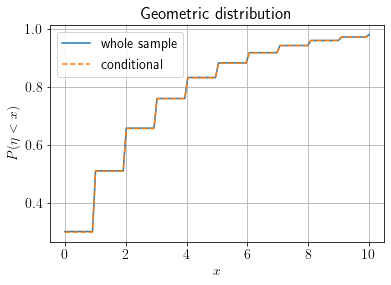

In [6]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
ax.plot(x, emp_all(x), label='whole sample')
ax.plot(x, emp_cond(x), '--', label='conditional')
ax.set_title('Geometric distribution')
ax.set_xlabel('$x$')
ax.set_ylabel(r'$P(\eta < x)$')
ax.grid('on')
ax.legend()

## 1.3

$\mathbb{E}[\xi] = 0,\ \mathrm{var}[\xi] = 1 \Rightarrow \mathbb{E}[S_i] = 0,\ \mathrm{var}[S_i] = n$.
Тогда из ЦПТ $Y_i = S_i \big/\!\sqrt n \rightarrow \mathscr{N}(0, 1)$ по распределению. 

In [7]:
N = int(1e6)
n = np.arange(1, N + 1)
r = 2 * gen_bernully(0.5, N) - 1
S = np.cumsum(r)
Y = S / np.sqrt(n)

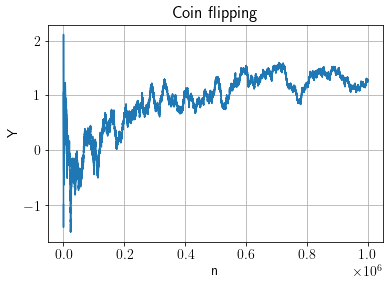

In [8]:
fig, ax = plt.subplots()
ax.plot(n, Y)
ax.set_title('Coin flipping')
ax.set_xlabel('n')
ax.set_ylabel('Y')
ax.grid('on')

# Задание 2

## 2.1

In [9]:
def gen_cantor(eps, gen_cdf, *shape):
    n_digits = np.ceil(-np.log(eps) / np.log(3)).astype(np.int64)
    bern = gen_bernully(0.5, *shape, n_digits)
    r = 2.0 * bern
    exp = lambda b: np.logspace(-1, -n_digits, n_digits, base=b)
    if gen_cdf:
        return r @ exp(3), bern @ exp(2)
    return r @ exp(3)

In [14]:
class CantorCDF:
    
    def __init__(self, eps=1e-10):
        self.n_digits = np.ceil(-np.log(eps) / np.log(3)).astype(np.int64)
        
    def __call__(self, x):
        shape = x.shape
        x = x.flatten()
        y = np.zeros_like(x)
        y[x >= 1] = 1
        idx = (x > 0) & (x < 1)
        x = x[idx]
        for i, el in enumerate(x):
            res = 0
            for j in range(1, self.n_digits + 1):
                k = np.floor(el * 3).astype(np.int64)
                if k > 0:
                    res += 2**-j
                el = (el - k / 3) * 3
                if k == 1:
                    break
            x[i] = res
        y[idx] = x
        return y.reshape(shape)

In [15]:
def my_kolm_test(rvs, cdf):
    idx = np.argsort(rvs)
    rvs = np.array([row[idx[i]] for i, row in enumerate(rvs)])
    ecdf_plus = np.arange(1, rvs.shape[-1] + 1) / rvs.shape[-1]
    ecdf_minus = np.arange(0, rvs.shape[-1]) / rvs.shape[-1]
    if callable(cdf):
        cdf = cdf(rvs)
    else:
        cdf = np.array([row[idx[i]] for i, row in enumerate(cdf)])
    d_stat_plus = np.max(ecdf_plus - cdf, axis=-1)
    d_stat_minus = np.max(cdf - ecdf_minus, axis=-1)
    d_stat = np.maximum(d_stat_plus, d_stat_minus)
    p = 1 - scs.kstwobign.cdf(d_stat * np.sqrt(rvs.shape[-1]))
    return p

In [16]:
N = 1000
N_SAMPLES = 1000
EPS = 1e-10

rvs, cdf = gen_cantor(EPS, True, N_SAMPLES, N)
rvs.shape

(1000, 1000)

In [17]:
alpha = 0.05
p = my_kolm_test(rvs, cdf)
print('Частота отклонения гипотизы: {}%'.format((p < alpha).sum() / N_SAMPLES * 100))

Частота отклонения гипотизы: 5.2%


## 2.2

In [18]:
def my_smir_test(rvs1, rvs2):
    rvs1 = np.sort(rvs1)
    rvs2 = np.sort(rvs2)
    all_data = np.concatenate((rvs1, rvs2))
    cdf1 = np.searchsorted(rvs1, all_data, side='right') / rvs1.size
    cdf2 = np.searchsorted(rvs2, all_data, side='right') / rvs2.size

    d_stat_plus = np.max(cdf1 - cdf2)
    d_stat_minus = np.clip(-np.min(cdf1 - cdf2), 0, 1)
    d_stat = np.max([d_stat_plus, d_stat_minus])
    p = 1 - scs.kstwobign.cdf(d_stat * np.sqrt(rvs1.size * rvs2.size / (rvs1.size + rvs2.size)))
    return p

### Симметрия


In [19]:
N = 10000
N_SAMPLES = 100
EPS = 1e-10
ALPHA = 0.05

n_reject = 0
for i in tqdm(np.arange(N_SAMPLES)):
    rvs = gen_cantor(EPS, False, N)
    p = my_smir_test(rvs, 1 - rvs)
    if p < ALPHA:
        n_reject += 1
print('Частота отклонения гипотизы: {}%'.format(n_reject / N_SAMPLES * 100))

100%|██████████| 100/100 [00:01<00:00, 72.04it/s]

Частота отклонения гипотизы: 10.0%


### Самоподобие

In [20]:
N = 10000
N_SAMPLES = 100
EPS = 1e-10
ALPHA = 0.05

n_reject = 0
for i in tqdm(np.arange(N_SAMPLES)):
    rvs = gen_cantor(EPS, False, N)
    p = my_smir_test(rvs[rvs < 1.0/3.0], rvs / 3.0)
    if p < ALPHA:
        n_reject += 1
print('Частота отклонения гипотизы: {}%'.format(n_reject / N_SAMPLES * 100))

100%|██████████| 100/100 [00:01<00:00, 83.43it/s]

Частота отклонения гипотизы: 3.0%


## 2.3

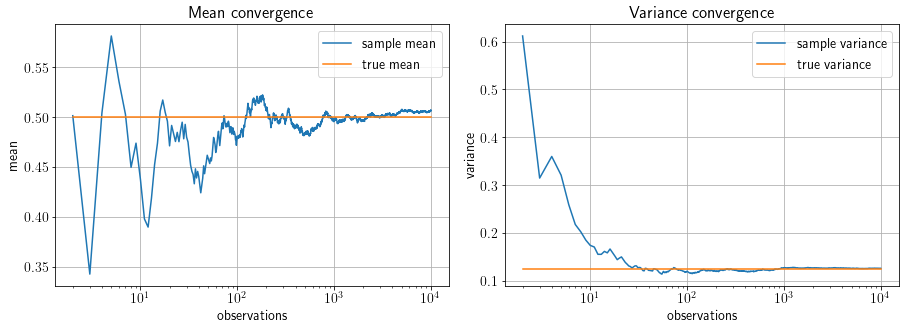

In [22]:
N = 10000
EPS = 1e-10
m = 0.5
v = 0.125

rvs = gen_cantor(EPS, False, N)
mean = np.cumsum(rvs) / np.arange(1, N + 1)
var = np.cumsum(rvs ** 2)[1:] / np.arange(1, N) - mean[1:]**2
n = np.arange(2, N + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax1.plot(n, mean[1:], label='sample mean')
ax1.plot([2, N], [m, m], label='true mean')
ax1.set_title('Mean convergence')
ax1.set_xlabel('observations')
ax1.set_xscale('log')
ax1.set_ylabel('mean')
ax1.grid('on')
ax1.legend()

ax2.plot(n, var, label='sample variance')
ax2.plot([2, N], [v, v], label='true variance')
ax2.set_title('Variance convergence')
ax2.set_xlabel('observations')
ax2.set_ylabel('variance')
ax2.set_xscale('log')
ax2.grid('on')
ax2.legend()

fig.tight_layout()

# Задание 3

## 3.1

In [23]:
def gen_exp(lam, *shape):
    rvs = rnd.rand(*shape)
    if isinstance(lam, float) or isinstance(lam, int):
        return -np.log(1 - rvs) / lam
    else:
        return -np.log(1 - rvs) / lam.reshape(-1, 1)

In [24]:
N = int(1e6)
THR = 5
LAM = 1
arr = gen_exp(LAM, N)

emp_all = ECDF(arr)
emp_cond = ECDF(arr[arr >= THR] - THR)

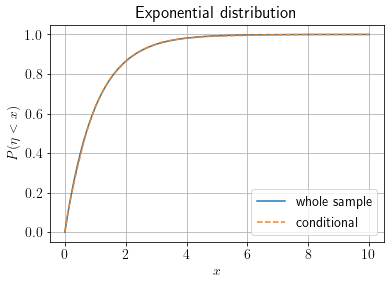

In [25]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
ax.plot(x, emp_all(x), label='whole sample')
ax.plot(x, emp_cond(x), '--', label='conditional')
ax.set_title('Exponential distribution')
ax.set_xlabel('$x$')
ax.set_ylabel(r'$P(\eta < x)$')
ax.grid('on')
ax.legend()

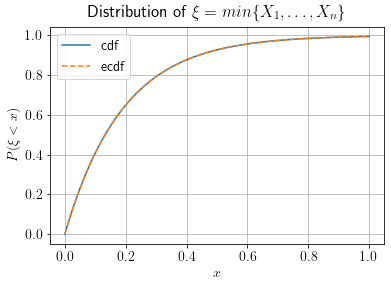

In [26]:
N_SAMPLES = 1000
N_LAM = 100

lam = rnd.rand(N_LAM) / 10
rvs = gen_exp(lam, N_LAM, N)
rvs = np.min(rvs, axis=0)

lam_min = lam.sum()

ecdf = ECDF(rvs)
cdf = lambda x: scs.distributions.expon.cdf(x, scale=1/lam_min)

fig, ax = plt.subplots()
x = np.linspace(0, 1, 100)
ax.plot(x, cdf(x), label='cdf')
ax.plot(x, ecdf(x), '--', label='ecdf')
ax.set_title(r'Distribution of $\xi = min\{X_1,\ldots,X_n\}$')
ax.set_xlabel('$x$')
ax.set_ylabel(r'$P(\xi < x)$')
ax.grid('on')
ax.legend()

## 3.2

Через пуассоновский процесс

In [27]:
def gen_pois_exp_single(lam):
    s = 0
    rv = -1
    while s < 1:
        s += gen_exp(lam)
        rv += 1
    return rv

def gen_pois_exp(lam, *shape):
    n = np.prod(shape)
    rvs = np.zeros(n)
    for i in range(n):
        rvs[i] = gen_pois_exp_single(lam)
    return rvs.reshape(shape)

## 3.3

In [28]:
def gen_pois_bin(lam, n, *shape):
    return gen_binomial(n, lam / n, *shape)

In [29]:
def pois_prob(lam, n):
    return np.exp(-lam) * lam**n / np.math.factorial(n)

In [30]:
LAM = 3
N_APPROX = 10000
N = 1000
N_SAMPLES = 100
N_BINS = 5
ALPHA = 0.05

n_reject = 0
probs = np.array([pois_prob(LAM, i) for i in range(1, N_BINS)])
probs[0] += pois_prob(LAM, 0)
probs = np.append(probs, 1 - probs.sum())

for i in tqdm(range(N_SAMPLES)):
    rvs = gen_pois_bin(LAM, N_APPROX, N)
    bins = np.zeros(N_BINS)
    for j in range(N_BINS + 1):
        if j == 0:
            bins[j] += (rvs == j).sum()
        elif j < N_BINS:
            bins[j - 1] += (rvs == j).sum()
        else:
            bins[j - 1] += (rvs >= j).sum()
    
    stat = ((bins - N * probs)**2 / (N * probs)).sum()
    if scs.distributions.chi2.cdf(stat, df=N_BINS-1) < ALPHA:
        n_reject += 1

print('Частота отклонения гипотизы: {}%'.format(n_reject / N_SAMPLES * 100))

100%|██████████| 100/100 [00:16<00:00,  5.63it/s]

Частота отклонения гипотизы: 3.0%


## 3.4

In [31]:
def gen_norm_polar(*shape):
    r = np.sqrt(gen_exp(0.5, *shape))
    phi = 2 * np.pi * rnd.rand(*shape)
    return r * np.cos(phi)

In [32]:
def my_t_test(rvs, mean):
    s = np.sqrt(rvs.var(axis=-1, ddof=1))
    tstats = np.sqrt(rvs.shape[-1]) * (rvs.mean(axis=-1) - mean) / s
    return scs.distributions.t.sf(np.abs(tstats), df=rvs.shape[-1]-1) * 2

In [33]:
N = 1000
N_SAMPLES = 100
ALPHA = 0.05

rvs = gen_norm_polar(N_SAMPLES, N)
p = my_t_test(rvs, 0)
n_reject = (p < ALPHA).sum()

print('Частота отклонения гипотизы: {}%'.format(n_reject / N_SAMPLES * 100))

Частота отклонения гипотизы: 3.0%


In [34]:
def my_f_test(rvs1, rvs2):
    s1 = rvs1.var(ddof=1)
    s2 = rvs2.var(ddof=1)
    n1 = rvs1.size
    n2 = rvs2.size
    
    if s1 < s2:
        s1, s2 = s2, s1
        n1, n2 = n2, n1
    
    stat = s1 / s2
    p = scs.distributions.f.sf(stat, n1 - 1, n2 - 1) * 2
    return p

In [35]:
N = 1000
N_SAMPLES = 100
ALPHA = 0.05

n_reject = 0
for i in tqdm(np.arange(N_SAMPLES)):
    rvs1 = gen_norm_polar(N)
    rvs2 = rnd.randn(N)
    p = my_f_test(rvs1, rvs2)
    if p < ALPHA:
        n_reject += 1
print('Частота отклонения гипотизы: {}%'.format(n_reject / N_SAMPLES * 100))

100%|██████████| 100/100 [00:00<00:00, 1658.46it/s]

Частота отклонения гипотизы: 6.0%


# Задание 4

## 4.1

In [36]:
def gen_cauchy(*shape):
    return np.tan(np.pi * (rnd.rand(*shape) - 0.5))

## 4.2

In [37]:
def gen_neumann(generator, pdf_proposal, pdf_target, k, size):

    rvs = np.empty(0)
    acception_rate = 1
    
    while rvs.size < size:
        cur_sz = int((size - rvs.size) / acception_rate)
        s = generator(cur_sz)
        ratio = pdf_target(s) / (k * pdf_proposal(s))
        s = s[rnd.rand(cur_sz) < ratio]
        acception_rate = max(s.size / cur_sz, 0.5)
        rvs = np.concatenate((rvs, s))
    
    return rvs

$k = \sup\limits_x \frac{p_{target}(x)}{p_{proposal}(x)} = \frac{2}{\sqrt{e}}$

In [38]:
pdf_target = lambda x: np.exp(-x**2 / 2)
pdf_proposal = lambda x: 1 / (1 + x**2)
k = 2 / np.exp(0.5)

In [39]:
N = 1000
rvs = gen_neumann(gen_cauchy, pdf_proposal, pdf_target, k, N)

In [40]:
def my_normplot(rvs, ax=None):
    (quants, vals), (k, b, _) = scs.probplot(rvs)
    
    if not ax:
        fig, ax = plt.subplots()
    
    ax.plot(vals, quants, 'o')
    ax.plot(k * quants + b, quants)
    ticks_perc = np.array([1, 5, 10, 20, 50, 80, 90, 95, 99])
    ticks_quan = scs.norm.ppf(ticks_perc / 100.)
    ax.set_yticks(ticks_quan)
    ax.set_yticklabels(ticks_perc)
    ax.set_xlabel('Sample')
    ax.set_ylabel('Probability')
    ax.grid('on')

Text(0.5, 1.0, 'Sample $3X + 1$')

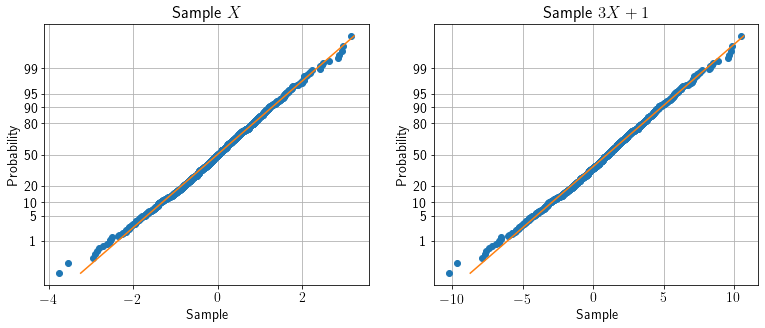

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

my_normplot(rvs, ax1)
ax1.set_title(r'Sample $X$')
my_normplot(3 * rvs + 1, ax2)
ax2.set_title(r'Sample $3X + 1$')

Строим соответствие вероятностей нормального распределения и выборочных квантилей

## 4.3

In [42]:
N_RUNS = 10
N_SIZES = 20

sizes = np.logspace(2, 6, N_SIZES).astype(np.int64)
times_polar = np.zeros((N_SIZES, N_RUNS))
times_neumannn = np.zeros((N_SIZES, N_RUNS))
times_numpy = np.zeros((N_SIZES, N_RUNS))

for i, sz in enumerate(tqdm(sizes)):
    for j in range(N_RUNS):
        
        start = time()
        rvs = gen_neumann(gen_cauchy, pdf_proposal, pdf_target, k, sz)
        stop = time()
        times_neumannn[i][j] = stop - start
        
        start = time()
        rvs = gen_norm_polar(sz)
        stop = time()
        times_polar[i][j] = stop - start
        
        start = time()
        rvs = rnd.randn(sz)
        stop = time()
        times_numpy[i][j] = stop - start

100%|██████████| 20/20 [00:07<00:00,  1.03it/s]


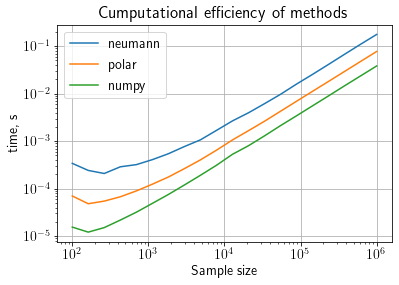

In [43]:
fig, ax = plt.subplots()

ax.plot(sizes, np.median(times_neumannn, axis=1), label='neumann')
ax.plot(sizes, np.median(times_polar, axis=1), label='polar')
ax.plot(sizes, np.median(times_numpy, axis=1), label='numpy')

ax.set_title('Cumputational efficiency of methods')
ax.set_xlabel('Sample size')
ax.set_ylabel('time, s')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid('on')
ax.legend()
plt.show()

# Задание 5

## 5.1

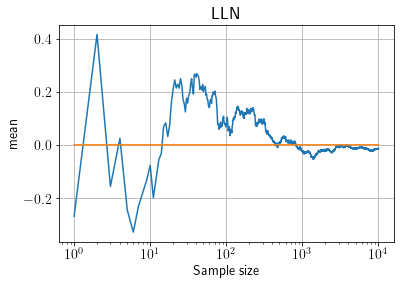

In [44]:
N = 10000

rvs = rnd.randn(N)
n = np.arange(1, N + 1)
means = rvs.cumsum() / n

fig, ax = plt.subplots()

ax.plot(n, means)
ax.plot(n, np.full_like(n, 0))
ax.set_xlabel('Sample size')
ax.set_ylabel('mean')
ax.set_xscale('log')
ax.set_title('LLN')
ax.grid('on')
plt.show()

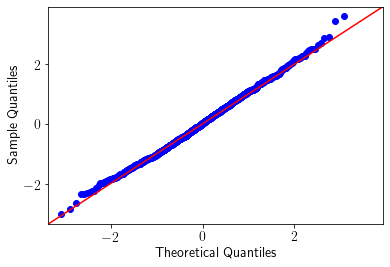

In [45]:
N_SAMPLES = 1000

rvs = rnd.randn(N_SAMPLES, N)
stats = rvs.sum(axis=1) / np.sqrt(N)

sm.qqplot(stats, line='45');

## 5.2

Пусть $\alpha$ — заданный уровень доверия, $m_n$ — выборочное математическое ожидание,
$s^2_n$ — несмещенная выборочная дисперсия.
Тогда статистика $\xi_n = \sqrt{n}\frac{m_n - \mu}{s_n} \sim St(n - 1)$.
Распределение Стьюдента симметрично, откуда доверительный интервал:

$$\mathbb{P}\left(\mu \in \left( m_n - \frac{s_n\gamma}{\sqrt{n}}, m_n + \frac{s_n\gamma}{\sqrt{n}} \right) \right) > \alpha,$$
если положить $\gamma$ равной квантили порядка $(1 + \alpha)/2$ распределения $St(n-1)$

In [65]:
ALPHA = 0.95
N = 15
sizes = np.logspace(1, 5, N).astype(int)
means = np.zeros(N)
err = np.zeros(N)

for i, n in enumerate(sizes):
    rvs = rnd.randn(n)
    means[i] = rvs.mean()
    s = np.sqrt(rvs.var(ddof=1))
    gamma = scs.t.ppf((1 + ALPHA) / 2, n - 1)
    err[i] = s * gamma / np.sqrt(n)

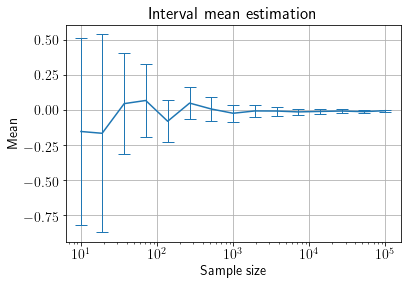

In [66]:
fig, ax = plt.subplots()

ax.errorbar(sizes, means, yerr=err, capsize=6, elinewidth=1)
ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('Mean')
ax.set_title('Interval mean estimation')
ax.grid('on')
plt.show()

Пусть теперь $s^2_n$ — смещенная выборочная дисперсия.
Статистика $\eta_n = \frac{n s^2_n}{\sigma^2}$ распределена по закону $\chi^2_{n-1}$.
Тогда для заданного уровня доверия $\alpha$:
$$\mathbb{P}\left(\sigma^2 \in \left( \frac{n s^2_n}{\gamma_1}, \frac{n s^2_n}{\gamma_2} \right) \right) > \alpha,$$
если положить $\gamma_i$ раными квантилям порядка $(1 - \alpha)/2$ и $(1 + \alpha)/2$ распределения $\chi^2_{n-1}$.

In [67]:
ALPHA = 0.95
N = 10
sizes = np.logspace(1, 5, N).astype(int)
var = np.zeros(N)
err = np.zeros((2, N))

for i, n in enumerate(sizes):
    rvs = rnd.randn(n)
    var[i] = rvs.var()
    gamma1 = scs.chi2.ppf((1 + ALPHA) / 2, n - 1)
    gamma2 = scs.chi2.ppf((1 - ALPHA) / 2, n - 1)
    err[0, i] = -n * var[i] / gamma1 + var[i]
    err[1, i] = n * var[i] / gamma2 - var[i]    

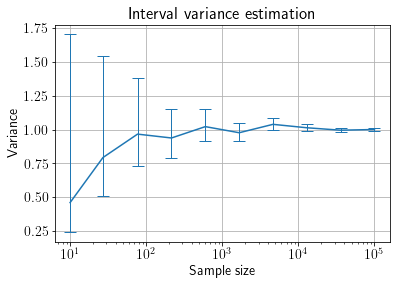

In [68]:
fig, ax = plt.subplots()

ax.errorbar(sizes, var, yerr=err, capsize=6, elinewidth=1)
ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('Variance')
ax.set_title('Interval variance estimation')
ax.grid('on')
plt.show()

## 5.3

Пусть $\xi \sim \mathcal{C}(0, 1)$.
Распределение Коши относится к семейству сдвиг-масштабных распределений.
Поэтому $a\xi + b \sim \mathcal{C}(a, b)$.
отсюда, если $\xi_n \sim \mathcal{C}(a, b)$, то и $S_n/n \sim \mathcal{C}(a, b)$.

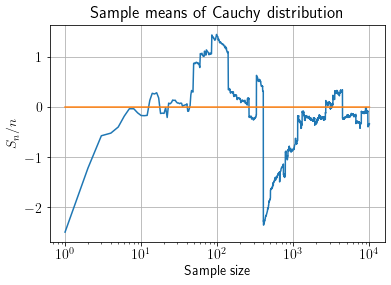

In [79]:
N = 10000

n = np.arange(1, N + 1)
rvs = gen_cauchy(N)
means = rvs.cumsum() / n

fig, ax = plt.subplots()

ax.plot(n, means)
ax.plot(n, np.full_like(n, 0))
ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel(r'$S_n/n$')
ax.set_title('Sample means of Cauchy distribution')
ax.grid('on')
plt.show()

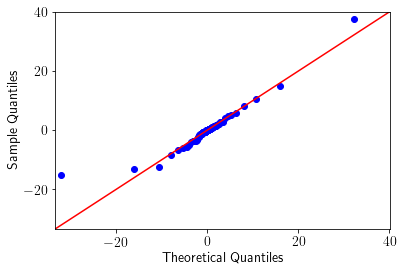

In [80]:
N = 1000
N_SAMPLES = 100

rvs = gen_cauchy(N_SAMPLES, N)

sm.qqplot(rvs.mean(axis=1), dist=scs.cauchy, line='45');

Ну close enought

# Задание 6

Заметим, что каждая переменная входит с квадратом, и функция инвариантна относительно перестановки аргументов, отсюда следует, что можно сильно сократить сетку (в 2 раза по каждой переменной).
Чтобы не ставить торч, можно запустить прямо в колабе:
https://colab.research.google.com/drive/16q000saiJyjYp-o5B7nyt9PDTK4zOePi?usp=sharing

In [ ]:
import torch

torch.cuda.is_available() 

In [ ]:
device = torch.device('cuda')
device

In [ ]:
def func(x: torch.tensor):
    tg_sq = torch.tan(x)**2
    s = (torch.sin(x)**2).prod(dim=-1)
    res = torch.zeros_like(s).to(x.device)

    # экспонента побеждает квадрат
    idx = torch.abs(s) > torch.finfo(s.dtype).eps
    res[idx] = torch.exp(-tg_sq.sum(dim=-1)[idx] - 
                         1 / (128.0 * tg_sq.prod(dim=-1)[idx])) / s[idx]

    return res

In [ ]:
class IdxIterator:

    def __init__(self, x_dim, n_grid, bs):
        self.x_dim = x_dim
        self.n_grid = n_grid
        self.bs = bs
        self.ok = True

    def __iter__(self):
        self.cur_idx = torch.zeros(self.x_dim, dtype=torch.int64)
        self.cur_idx[-1] = -1
        self.comp = torch.arange(self.n_grid).reshape(-1, 1)
        return self
    
    def __next__(self):

        if not self.ok:
            raise StopIteration

        res = torch.zeros(self.bs, self.x_dim, dtype=torch.int64)
        log_coeffs = torch.zeros(self.bs)

        for j in range(res.shape[0]):
            self.ok = False
            
            for i in range(1, len(self.cur_idx) + 1):
                if self.cur_idx[-i] < self.n_grid - 1:
                    self.cur_idx[-i] += 1
                    self.cur_idx[-i:] = torch.full_like(self.cur_idx[-i:], self.cur_idx[-i])
                    num_rep = (self.comp == self.cur_idx).sum(dim=-1).type(torch.double)
                    log_coeffs[j] = torch.lgamma(torch.tensor(1 + self.x_dim, dtype=torch.double)) -\
                       torch.lgamma(1.0 + num_rep).sum()
                    self.ok = True
                    break

            if not self.ok:
                return res[:j, :], torch.exp(log_coeffs[:j])
            
            res[j] = self.cur_idx
        return (res, torch.exp(log_coeffs))

In [ ]:
%%time

N_GRID = 15
X_DIM = 10
BS = 2**16

start = np.pi / (4 * N_GRID)
end = np.pi / 2 - start
h = np.pi / (2 * N_GRID)

res = torch.tensor(0, dtype=torch.float64).to(device)
idx = torch.zeros(X_DIM, dtype=torch.int64).to(device)
flat_grid = torch.linspace(start, end, N_GRID, dtype=torch.float64).to(device)
idx_iterator = iter(IdxIterator(X_DIM, N_GRID, BS))

for idx, coeffs in idx_iterator:
    res += (h**X_DIM * coeffs.to(device) * func(flat_grid[idx])).sum()

res *= 2**X_DIM # символизирует четность функции по каждой переменной
print(res.item())

# Метод Монте-Карло

In [ ]:
def g(x: torch.tensor):
    prod = (x**2).prod(dim=-1)
    res = torch.zeros_like(prod, device=x.device)
    idx = torch.abs(prod) > torch.finfo(prod.dtype).eps
    res[idx] = np.pi**5 * torch.exp(-1 / (128.0 * prod[idx])) / prod[idx]
    return res

In [ ]:
class BatchSampler:
    def __init__(self, bs, sigma, dim, n_samples, device):
        self.bs = bs
        self.sigma = sigma
        self.dim = dim
        self.n_samples = n_samples
        self.device = device
    
    def __iter__(self):
        self.cur_sample = 0
        return self
    
    def __next__(self):
        
        if self.cur_sample == self.n_samples:
            raise StopIteration

        n = min(self.n_samples - self.cur_sample, self.bs)
        self.cur_sample += n
        return self.sigma * torch.randn(n, self.dim).to(device), n

In [ ]:
%%time

BS = 10**7
X_DIM = 10
N_SAMPLES = 10**10

batch_sampler = BatchSampler(BS, 1 / np.sqrt(2), X_DIM, N_SAMPLES, device)

res = 0
n_prev = n_cur = 0
m = 0
for sample, n_cur in batch_sampler:
    cur = g(sample).mean()
    m += (cur - m) * n_cur / (n_cur + n_prev)
    n_prev += n_cur

print(m.item())

In [ ]:
sample = 1 / np.sqrt(2) * torch.randn(BS, X_DIM).to(device) # оценка дисперсии интеграла
alpha = 0.05
var = g(sample).var().item()
eps = np.sqrt(var / N_SAMPLES / alpha) # нер-во Чебышева
eps